# 第二次大作业：对CIFAR-10数据集进行分类

# 1.导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

数据集与加载配置
使用CIFAR-10数据集，包含50,000张训练图像和10,000张测试图像，均为32×32彩色图像。数据加载器批量大小为128，训练时打乱顺序，使用4个工作进程并启用内存锁定以加速数据加载。

# 2.定义网络

第一部分由三个卷积块堆叠构成。每个卷积块中均使用 3×3 的卷积核，并设置填充为 1，以保持特征图空间尺寸不变。各卷积块均包含批归一化（BatchNorm2d）与 ReLU 激活函数，结构如下：

 第一个卷积块：输入通道数为 3，输出通道数为 64，经两次卷积操作，每次卷积后接 BatchNorm2d 与 ReLU 激活函数。

第二个卷积块：输入通道数为 64，输出通道数为 128，经两次卷积操作，每次卷积后接 BatchNorm2d 与 ReLU 激活函数。

第三个卷积块：输入通道数为 128，输出通道数为 256，经两次卷积操作，每次卷积后接 BatchNorm2d 与 ReLU 激活函数。


第二部分是通道注意力模块​，该模块首先通过全局平均池化获取各通道的全局信息，随后经过两个逐点卷积（1×1卷积）实现对通道关系的建模，并使用Sigmoid（0至1）函数生成通道注意力权重。具体结构如下：

全局平均池化（AdaptiveAvgPool2d），将任意尺寸特征图压缩为1×1。

第一个逐点卷积：输入通道数为256，输出通道数为16，对通道进行压缩，后接ReLU激活函数。

第二个逐点卷积：输入通道数为16，输出通道数为256，恢复通道维度，后接Sigmoid函数，输出归一化的通道注意力权重。

第三部分是分类器模块​，该部分由三层全连接层构成，采用Dropout、批归一化与ReLU激活函数进行正则化与非线性变换，最终输出对应类别数。具体结构如下：
第一层：输入维度256，输出维度512，前接Dropout（0.3），后接批归一化（BatchNorm1d）与ReLU激活函数。

第二层：输入维度512，输出维度256，前接Dropout（0.4），后接批归一化与ReLU激活函数。

第三层：输入维度256，输出维度为类别数（num_classes），前接Dropout（0.2）。


In [4]:
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
       
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # 注意力机制
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 256, kernel_size=1),
            nn.Sigmoid()
        )
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Block 1
        x = self.conv_block1(x)
        x = F.max_pool2d(x, 2)  # 16x16
        
        # Block 2  
        x = self.conv_block2(x)
        x = F.max_pool2d(x, 2)  # 8x8
        
        # Block 3
        x = self.conv_block3(x)
        
        # 注意力机制
        attention_weights = self.attention(x)
        x = x * attention_weights
        
        # 全局池化
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        # 分类
        x = self.classifier(x)
        return x

# 3.数据加载及数据增强
1. 使用CIFAR-10数据集，包含50,000张训练图像和10,000张测试图像，均为32×32彩色图像。数据加载器批量大小为128，训练时打乱顺序，使用4个工作进程并启用内存锁定以加速数据加载。

2. 数据训练数据增强：

   - 几何变换：随机水平翻转（概率0.5）、随机裁剪（32×32输入，填充4像素）、随机旋转（±15度）、随机平移（水平垂直方向各10%）

   - 色彩变换：调整亮度、对比度、饱和度（幅度均为±0.3）和色相（幅度±0.1）

   - 标准化：转换为张量后，使用CIFAR-10的统计量进行标准化（均值[0.4914, 0.4822, 0.4465]，标准差[0.2470, 0.2435, 0.2616]）

   - 正则化：最后应用随机擦除（概率0.2）

3. 测试数据处理：

   - 仅进行张量转换和相同参数的标准化，不进行任何增强。

In [5]:
def data_loaders(batch_size=128):
    # 数据增强
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.2)  # 随机擦除
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    # 加载数据集
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    
    test_dataset = datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    
    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
    )
    
    return train_loader, test_loader

# 4.训练策略
1. 优化器配置
优化器：随机梯度下降（SGD）结合动量优化。初始学习率：0.1；动量：0.9；权重衰减：5×10⁻⁴（L2正则化），使用Nesterov动量。
2. 学习率调度策略
预热阶段：前5个epoch线性增加学习率，从初始学习率的10%逐渐增加到100%
余弦退火：预热结束后采用余弦退火调度，在剩余训练周期内平滑降低学习率
3. 损失函数
交叉熵损失：使用标签平滑技术（平滑系数0.1），防止模型对训练标签过度自信
4. 训练优化技术
混合精度训练：使用自动混合精度（AMP）加速训练并减少显存占用
梯度裁剪：限制梯度范数不超过1.0，防止梯度爆炸
模型选择：保存整个训练过程中验证集上表现最佳的模型参数
5. 训练过程
每个epoch记录训练损失、训练准确率和测试准确率
实时监控并输出当前学习率、损失和准确率指标
训练完成后自动加载最佳模型参数
6. 训练环境
自动检测并使用GPU（若可用），否则回退到CPU

In [6]:
# 训练策略
def train_model(model, train_loader, test_loader, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # 使用SGD + Momentum + 权重衰减
    optimizer = optim.SGD(
        model.parameters(), 
        lr=0.1, 
        momentum=0.9, 
        weight_decay=5e-4,
        nesterov=True
    )
    
    # 改进的学习率调度：热身 + 余弦退火
    warmup_epochs = 5
    scheduler = lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[
            lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs),
            lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-warmup_epochs)
        ],
        milestones=[warmup_epochs]
    )
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 标签平滑
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    best_acc = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # 混合精度训练
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        scheduler.step()
        
        # 计算训练准确率
        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)
        
        # 测试准确率
        test_acc = evaluate_model(model, test_loader, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = model.state_dict().copy()
        
        current_lr = optimizer.param_groups[0]['lr']
        if (epoch+1) %5 ==0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'LR: {current_lr:.6f}, 训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%')
            print(f'测试准确率: {test_acc:.2f}%, 最佳准确率: {best_acc:.2f}%')
            print('-' * 60)
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, train_accuracies, test_accuracies, best_acc


模型评估函数：用于在测试集上计算模型的分类准确率。不包含梯度计算和参数更新。

In [7]:
# 评估函数
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return 100. * correct / total

若原模型的准确率无法达到90%以上，则使用模型集成策，即通过对多个独立模型的预测结果进行概率平均，获得比单一模型更稳定、更准确的集成预测结果。

In [8]:
# 集成预测
def ensemble_predict(models, test_loader, device):
    """多个模型的集成预测"""
    for model in models:
        model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 对每个模型进行预测
            model_preds = []
            for model in models:
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)
                model_preds.append(probs)
            
            # 平均概率
            avg_probs = torch.stack(model_preds).mean(0)
            _, predicted = avg_probs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100.0 * accuracy_score(all_targets, all_preds)
    return accuracy

# 5 整体流程概述
本主函数实现了完整的模型训练、评估和可视化流程，包含以下主要阶段：
1. 环境初始化与随机种子设置
2. 数据加载与模型构建
3. 模型训练与监控
4. 结果可视化与分析
5. 模型集成与性能提升

In [20]:
# 主函数
def main():
    # 设置随机种子
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # 获取数据加载器
    train_loader, test_loader = data_loaders(batch_size=128)
    
    # 创建模型
    model = CIFAR10CNN()
    
    # 打印模型结构
    #print("模型结构:")
    #print(model)
    #print(f"参数数量: {sum(p.numel() for p in model.parameters()):,}")
    
    # 训练模型
    train_losses, train_accuracies, test_accuracies, best_acc = train_model(
        model, train_loader, test_loader, epochs=50
    )

    
    # 绘制训练曲线
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(test_accuracies, color='orange')
    plt.title('Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 最终测试准确率
    final_test_acc = evaluate_model(model, test_loader, 
                                  torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    print(f'最终测试准确率: {final_test_acc:.2f}%')
    print(f'最佳测试准确率: {best_acc:.2f}%')
    
    # 如果准确率还不够，尝试模型集成
    if best_acc < 90:
        print("\n训练多个模型进行集成...")
        models = []
        for i in range(3):  # 训练3个模型
            print(f"训练第{i+1}个模型...")
            model_i = CIFAR10CNN()
            _, _, _, acc_i = train_model(model_i, train_loader, test_loader, epochs=15)
            models.append(model_i)
            print(f"模型{i+1}准确率: {acc_i:.2f}%")
        
        ensemble_acc = ensemble_predict(models, test_loader, 
                                      torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        print(f"集成模型准确率: {ensemble_acc:.2f}%")

/tmp/ipykernel_3464/921422656.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [5/50]
LR: 0.100000, 训练损失: 1.3659, 训练准确率: 61.29%
测试准确率: 68.84%, 最佳准确率: 68.84%
------------------------------------------------------------
Epoch [10/50]
LR: 0.096985, 训练损失: 1.1623, 训练准确率: 71.04%
测试准确率: 76.56%, 最佳准确率: 77.06%
------------------------------------------------------------
Epoch [15/50]
LR: 0.088302, 训练损失: 1.0930, 训练准确率: 74.21%
测试准确率: 79.63%, 最佳准确率: 79.63%
------------------------------------------------------------
Epoch [20/50]
LR: 0.075000, 训练损失: 1.0496, 训练准确率: 76.24%
测试准确率: 81.73%, 最佳准确率: 82.28%
------------------------------------------------------------
Epoch [25/50]
LR: 0.058682, 训练损失: 0.9976, 训练准确率: 78.37%
测试准确率: 81.41%, 最佳准确率: 84.48%
------------------------------------------------------------
Epoch [30/50]
LR: 0.041318, 训练损失: 0.9419, 训练准确率: 81.04%
测试准确率: 84.76%, 最佳准确率: 84.80%
------------------------------------------------------------
Epoch [35/50]
LR: 0.025000, 训练损失: 0.8730, 训练准确率: 84.12%
测试准确率: 87.56%, 最佳准确率: 87.56%
----------------------------------------

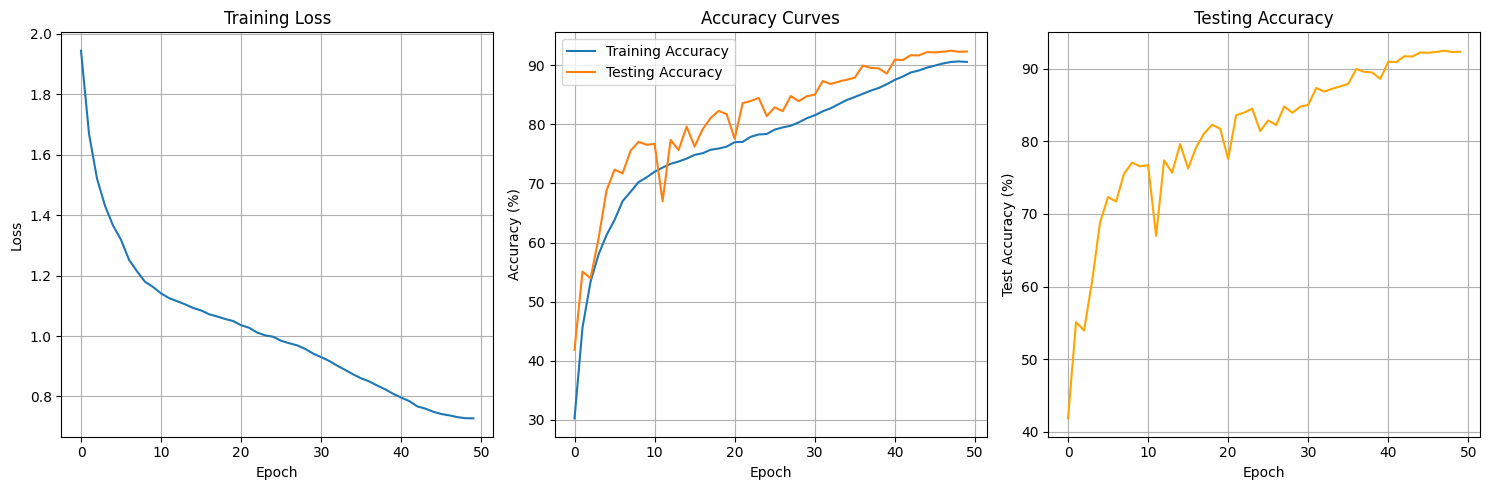

最终测试准确率: 92.33%
最佳测试准确率: 92.47%


In [21]:
if __name__ == "__main__":
    main()

根据损失函数图像可知，在前10个周期时，下降较快，后面逐渐变慢，不过不能确定在第五十个周期是否收敛(学习率在最终周期已衰减至接近0（余弦退火策略))。但考虑到准确率到达90%以上，就没有再增加训练周期了。另外，如果想缩短训练周期，也可以使用集成模型。